In [3]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

/home/plau/anaconda3/envs/timeGAN/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
class LSTMGenerator(nn.Module):
    """Generator with LSTM"""
    def __init__(self, latent_dim, ts_dim, hidden_dim=256, num_layers=1):
        super(LSTMGenerator, self).__init__()

        self.ts_dim = ts_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(num_layers*hidden_dim, num_layers*ts_dim)

    def forward(self, x):
        x = x.reshape(x.shape[0], self.num_layers, x.shape[1])
        out, _ = self.lstm(x)
        out = self.linear(out.reshape(x.size(0), x.size(1)*self.hidden_dim))
        out = out.view(x.size(0), self.ts_dim, self.num_layers)
        return out

In [16]:
noise_len = 32
n_samples = 24
n_groups = 6

In [24]:
models_directory = 'models'
Fakedata_directory = 'COSCI-GAN/GeneratedData'

In [18]:
generator_coscigan = {}

for i in range(n_groups):
    generator_coscigan[i] = LSTMGenerator(noise_len, n_samples)

In [20]:
for i in range(n_groups):
    # LSTM MLP
    
    # With CD 0
    generator_coscigan_temp_dict = torch.load(f'/home/plau/Documents/CityU/AlgoTrade/COSCI-GAN/Results/Models/with_CD/with_CD_LSTM_G_LSTM_D_CD_type_MLP_6_100_0_57_stock_data_24_100_32_24_BCE_gamma_5.0_Glr_0.001_Dlr_0.001_CDlr_0.0001_noiselen_32_Generator_0.pt', map_location=torch.device('cpu'))
    new_generator_coscigan_temp_dict = deepcopy(generator_coscigan_temp_dict)
    for key in generator_coscigan_temp_dict.keys():
        new_generator_coscigan_temp_dict[key[7:]] = new_generator_coscigan_temp_dict.pop(key)
    generator_coscigan[i].load_state_dict(new_generator_coscigan_temp_dict)

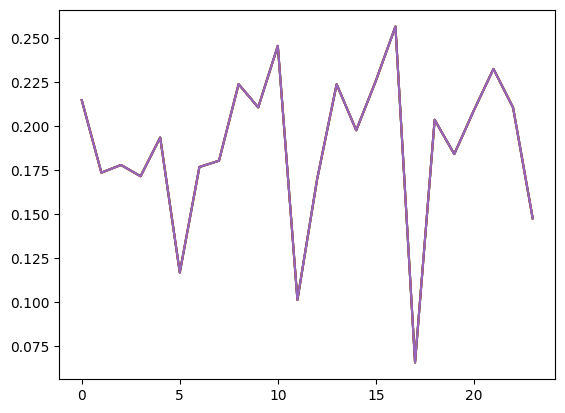

In [21]:
new_noise = torch.randn((1024, noise_len)).float()

generated_samples_coscigan = {}

for i in range(n_groups):
    generated_samples_coscigan[i] = generator_coscigan[i](new_noise).detach().cpu().numpy()
    
plt.figure()
plt.plot(generated_samples_coscigan[0][0, :], label='Channel 1')
plt.plot(generated_samples_coscigan[1][0, :], label='Channel 2')
plt.plot(generated_samples_coscigan[2][0, :], label='Channel 3')
plt.plot(generated_samples_coscigan[3][0, :], label='Channel 4')
plt.plot(generated_samples_coscigan[4][0, :], label='Channel 5')
plt.show()

In [22]:
# create dataframe of generated samples
generated_samples_coscigan_df = {}

for i in range(n_groups):
    generated_samples_coscigan_df[i] = pd.DataFrame(generated_samples_coscigan[i].squeeze())

In [28]:
# save generated samples to csv

pd.concat([generated for generated in generated_samples_coscigan_df.values()], axis=1, ignore_index=True).to_csv(f'/home/plau/Documents/CityU/AlgoTrade/COSCI-GAN/GeneratedData/generated_samples_coscigan.csv', index=False)

In [29]:
import pandas as pd
import numpy as np

In [32]:
data = np.array(pd.read_csv('/home/plau/Documents/CityU/AlgoTrade/COSCI-GAN/GeneratedData/generated_stock_data.csv'))

data = data.reshape(data.shape[0], -1, 6)

In [10]:
np.save('Fake_Data/eeg_generated_samples_coscigan.npy', data)